## Identify the animals
Make sure to point the symbolic link "fasiai" to the fastai library

https://www.hackerearth.com/problem/machine-learning/predict-the-energy-used-612632a9-9de79188/


In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
PATH = "data/dogscats/"
print(torch.cuda.is_available())
print(torch.backends.cudnn.enabled)
#assign GPU device
torch.cuda.set_device(0)

True
True


In [4]:
print(os.listdir(f'{PATH}'))
print(os.listdir(f'{PATH}/train'))
samplefiles=os.listdir(f'{PATH}/valid/dogs')[:5]
samplefiles

['sample', 'train', 'valid', 'models', 'tmp', 'test1']
['dogs', 'cats']


['dog.5660.jpg',
 'dog.8029.jpg',
 'dog.4708.jpg',
 'dog.1432.jpg',
 'dog.2979.jpg']

(422, 492, 3)


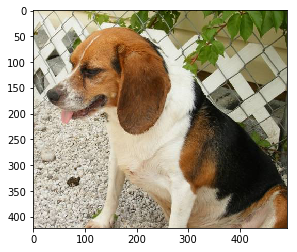

In [5]:
img = plt.imread(f'{PATH}/valid/dogs/{samplefiles[0]}')
plt.imshow(img)
print(img.shape)

In [6]:
#data
print(len(os.listdir(f'{PATH}/train/cats')))
print(len(os.listdir(f'{PATH}/valid/cats')))

11500
1000


In [7]:
#Use ImageNet pre-trained model
arch=resnet34
sz=224
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))

 79%|███████▉  | 286/360 [00:02<00:00, 114.00it/s, loss=0.373] 


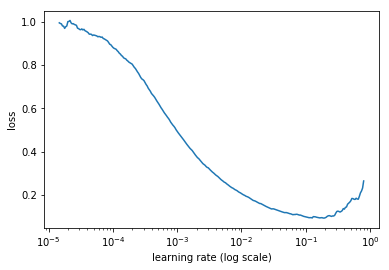

In [8]:
learn = ConvLearner.pretrained(arch, data, precompute=True)
lrf=learn.lr_find()
learn.sched.plot()

In [9]:
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 3)

epoch      trn_loss   val_loss   accuracy                      
    0      0.050264   0.021985   0.9915    
    1      0.039637   0.022351   0.992                         
    2      0.030283   0.022284   0.9915                        



[array([0.02228]), 0.9915]

## Data augumentation

In [10]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 3)

epoch      trn_loss   val_loss   accuracy                      
    0      0.042783   0.024848   0.9905    
    1      0.038662   0.023848   0.99                          
    2      0.037141   0.023253   0.99                          



[array([0.02325]), 0.99]

epoch      trn_loss   val_loss   accuracy                     
    0      0.039699   0.026044   0.9895    
    1      0.044412   0.024813   0.991                        
    2      0.038584   0.024231   0.991                        



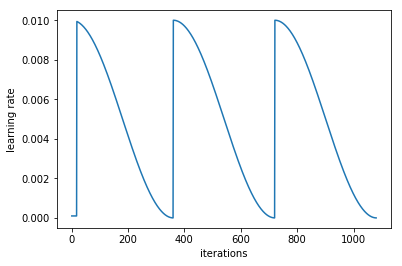

In [11]:
## unfreeze the last layer and retrain
learn.precompute=False
learn.fit(1e-2, 3, cycle_len=1)
learn.sched.plot_lr()

epoch      trn_loss   val_loss   accuracy                     
    0      0.051956   0.024196   0.992     
    1      0.03949    0.024027   0.9875                       
    2      0.02948    0.022192   0.99                         
    3      0.032196   0.018613   0.9915                       
    4      0.030258   0.021864   0.99                         
    5      0.019644   0.018112   0.9925                       
    6      0.022577   0.018012   0.9915                       

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 3.81 µs


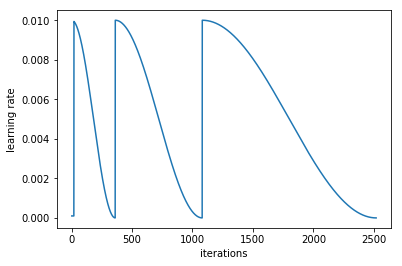

In [12]:
# unfreeze all layers and fine tune the model
learn.unfreeze()
lr=np.array([1e-4,1e-3,1e-2])
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)
learn.sched.plot_lr()
%time

In [145]:
# Regular prediction without TTA  -- use validation dataset
log_preds = learn.predict()
probs = np.exp(log_preds)        
preds = np.argmax(log_preds, axis=1)
accuracy_np(probs, y)

0.9915

In [148]:
# TTA (test time data augumentation)  -- use validation dataset
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y)

0.994

[[996   4]
 [ 13 987]]


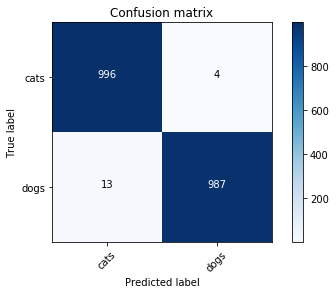

In [146]:
# Confusion Matrics
preds = np.argmax(probs, axis=1)
probs = probs[:,1]
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)
plot_confusion_matrix(cm, data.classes)

In [149]:
#functions to display data
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Correctly classified


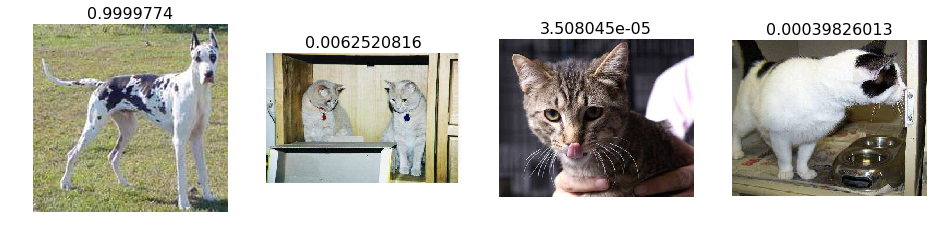

In [134]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


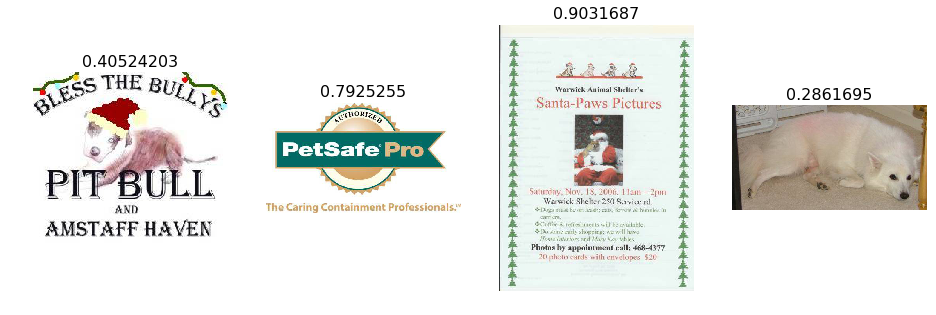

In [135]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

Most correct cats


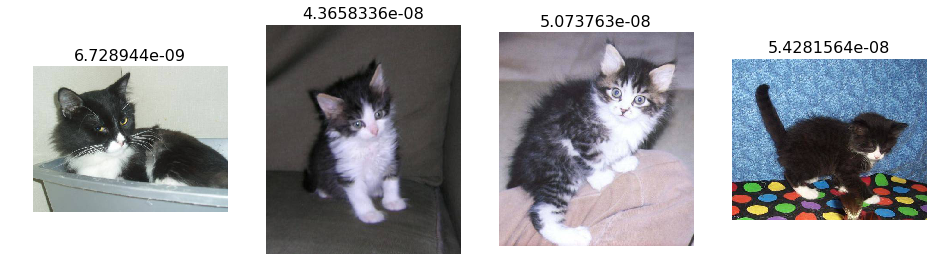

In [136]:
plot_val_with_title(most_by_correct(0, True), "Most correct cats")

Most correct dogs


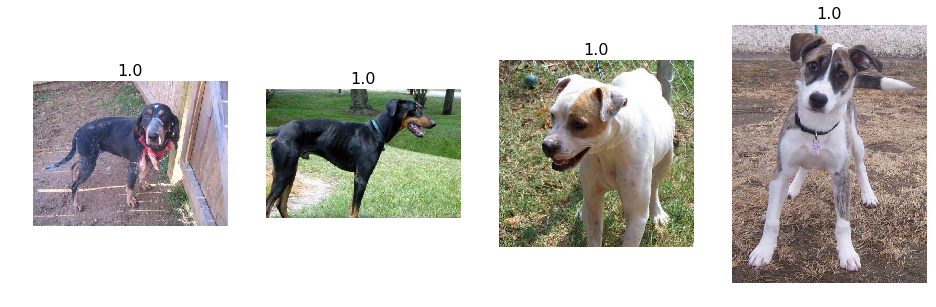

In [137]:
plot_val_with_title(most_by_correct(1, True), "Most correct dogs")

Most incorrect cats


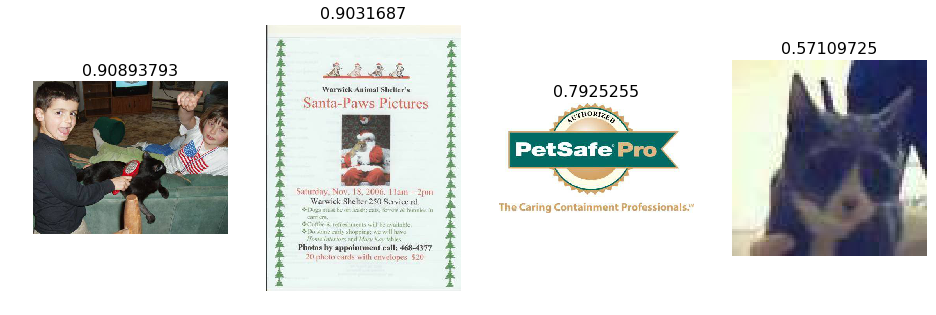

In [138]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


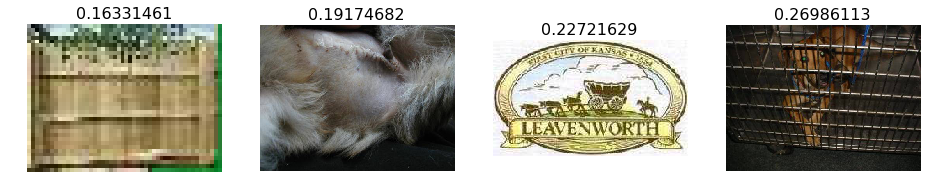

In [139]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

Most uncertain predictions


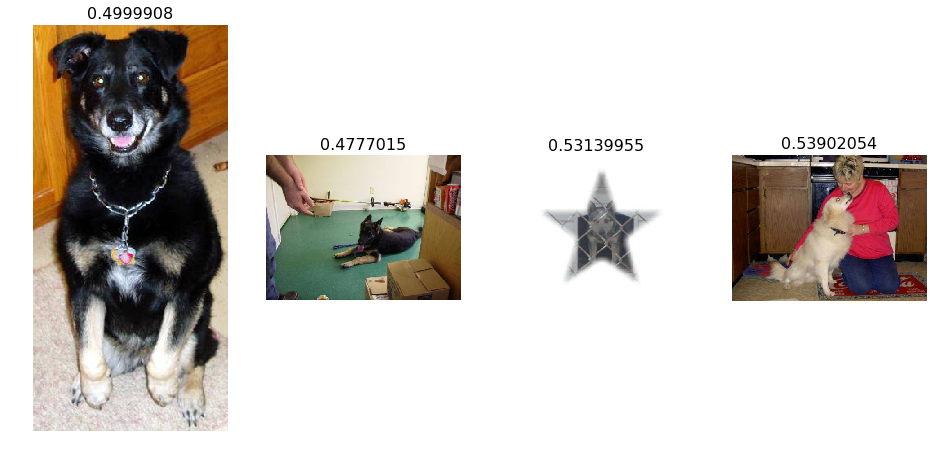

In [140]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")